In [1]:
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=12'

%load_ext autoreload
%autoreload 2
%matplotlib inline

from brax import envs
from brax.io import html, model
from brax.training import normalization
from numpy.random import default_rng
import pickle
import ce_apg
rng = default_rng()

import flax
import jax
import jax.numpy as jnp
from brax.envs import create_fn

from IPython.display import HTML, clear_output

import optax

import matplotlib.pyplot as plt
import numpy as np

from controllers import GruController, MlpController, LinearController

from functools import partial
from matplotlib import cm


jax.config.update('jax_platform_name', 'cpu')

def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps, height=height))

len(jax.devices())

1

In [2]:
episode_length = 500
action_repeat = 1
save_dir = "./save_ce_apg2"


env_name = "acrobot"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]
env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
env = env_fn()
policy = GruController(env.observation_size,env.action_size, 16)
#policy = pickle.load(open(f"{save_dir}/{env_name}_policy", 'rb'))

seed = 1
inference_fn = jax.jit(ce_apg.make_inference_fn(
    env.observation_size, env.action_size, True, policy))

#params = model.load_params(f"{save_dir}/{env_name}_params_{seed}")
#normalizer_params, original_policy_params = params
#policy_params_flat, policy_params_def = jax.tree_flatten(original_policy_params)


key = jax.random.PRNGKey(1)
reset_keys = jax.random.split(key, num=jax.local_device_count())
key, model_key = jax.random.split(key)
noise_keys = jax.random.split(model_key, num=jax.local_device_count())

init_states = jax.pmap(env.reset)(reset_keys)
x0 = init_states.obs
h0 = jnp.zeros(env.observation_size)

original_policy_params = policy.init(model_key, h0, x0)
policy_params_flat, policy_params_def = jax.tree_flatten(original_policy_params)



import brax.jumpy as jp
@jax.jit
def do_rnn_rollout(params, key):
    init_state = env.reset(key)
    h0 = jp.zeros_like(init_state.obs)

    def do_one_rnn_step(carry, step_idx):
        state, h  = carry

        #h1 , actions = inference_fn(params, h, state.obs)
        h1, actions = policy.apply(params,h,state.obs)
        #actions = jp.ones_like(actions)*0.0
        nstate = env.step(state, actions)    
        #h1 = jax.lax.cond(nstate.done, lambda x: jnp.zeros_like(h1), lambda x: h1, None)
        return (jax.lax.stop_gradient(nstate), h1), (nstate.reward,state.obs, actions, nstate)


    _, (rewards, obs, acts, states) = jp.scan(
        do_one_rnn_step, (init_state, h0),
        (jnp.array(range(episode_length // action_repeat))),
        length=episode_length // action_repeat)

    return rewards, obs, acts, states

In [3]:
%%time

reward_sums_list = []
for _ in range(4):

    param_vec_list = []
    policy_params_flat, policy_params_def = jax.tree_flatten(original_policy_params)

    for p in policy_params_flat:
        param_vec_list.append(p.flatten())

    params_vec = np.concatenate(param_vec_list)
    random_direction = rng.standard_normal(params_vec.shape, dtype=np.float32)
    #random_direction /= np.linalg.norm(random_direction)
    n_points = 200
    step_size = 2*1/(n_points)

    shift_list = [(i-n_points//2)*step_size for i in range(n_points)]
    random_params_vec_list = [params_vec + shift*random_direction for shift in shift_list]
    
    random_params_flat_list = []
    for random_params_vec in random_params_vec_list:
        i = 0
        random_params_flat = []
        for old_param in policy_params_flat:
            new_param_num = old_param.size
            random_params_flat.append(random_params_vec[i:i+new_param_num].reshape(old_param.shape))
            i += new_param_num
        random_params_flat_list.append(random_params_flat)
        
    key = jax.random.PRNGKey(0)
    reward_sums = []
    for random_params in random_params_flat_list:
        policy_params = jax.tree_unflatten(policy_params_def, random_params)
        params = policy_params
        rewards, obs, acts, states = do_rnn_rollout(params, key)
        reward_sums.append(sum(rewards).item())

    import matplotlib.pyplot as plt
    #plt.plot(reward_sums);
    reward_sums_list.append(reward_sums)

CPU times: user 6min 49s, sys: 6.37 s, total: 6min 55s
Wall time: 6min 42s


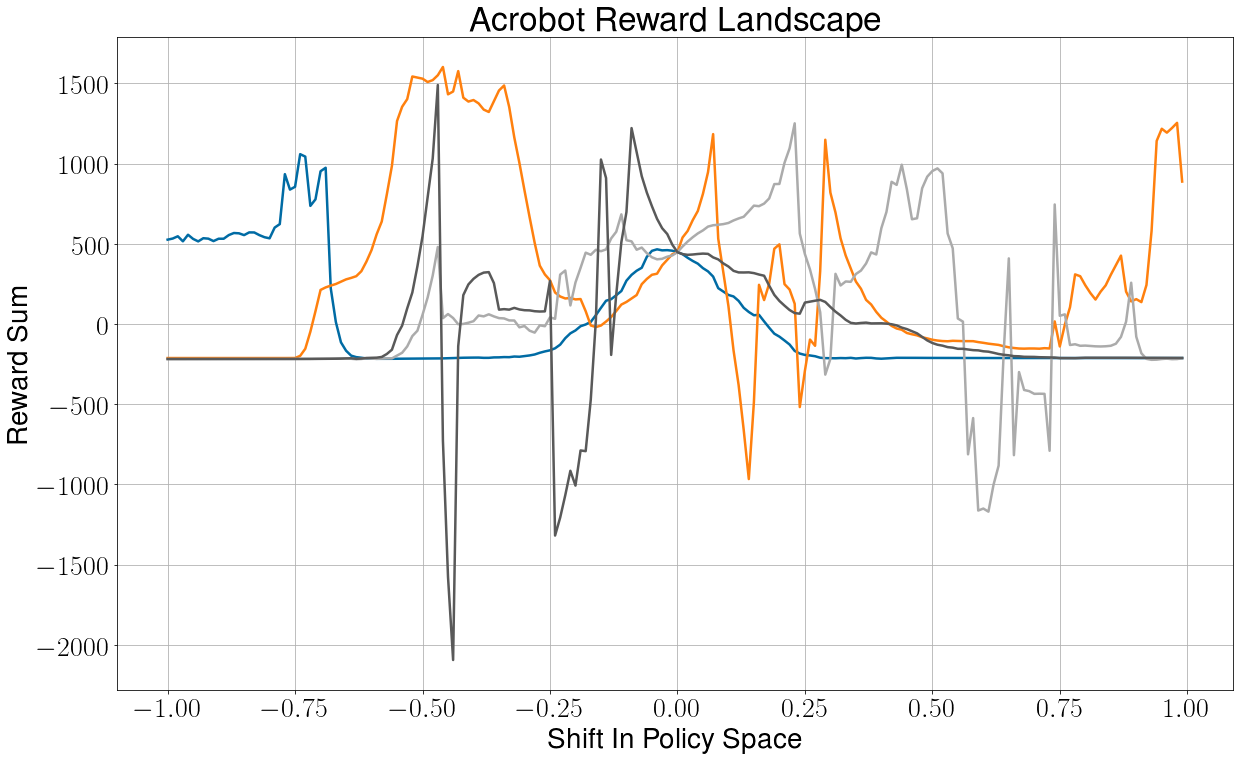

In [21]:
with plt.style.context('tableau-colorblind10'):
    plt.rcParams['text.usetex'] = True
    plt.rcParams["font.serif"] = "Helvetica"
    plt.rcParams["font.size"] = 28
    #plt.style.use('seaborn-paper')
    a = np.stack(reward_sums_list)
    plt.figure(figsize=(20,12))
    plt.plot(shift_list, a.T, linewidth=2.5);
    plt.title("Acrobot Reward Landscape")
    plt.ylabel('Reward Sum')
    plt.xlabel('Shift In Policy Space')
    plt.grid()

In [4]:
def make_random_vec_list(original_policy_params, n_points = 50):
    param_vec_list = []
    policy_params_flat, policy_params_def = jax.tree_flatten(original_policy_params)

    for p in policy_params_flat:
        param_vec_list.append(p.flatten())

    params_vec = np.concatenate(param_vec_list)
    random_direction = rng.standard_normal(params_vec.shape, dtype=np.float32)
    random_direction /= np.linalg.norm(random_direction)
    step_size = .5/(n_points)
    random_params_vec_list = [params_vec + (i-n_points//2)*step_size*random_direction for i in range(n_points)]
    
    return random_params_vec_list, random_direction

#     random_params_flat_list = []
#     for random_params_vec in random_params_vec_list:
#         i = 0
#         random_params_flat = []
#         for old_param in policy_params_flat:
#             new_param_num = old_param.size
#             random_params_flat.append(random_params_vec[i:i+new_param_num].reshape(old_param.shape))
#             i += new_param_num
#         random_params_flat_list.append(random_params_flat)
    
#     return random_params_flat_list

In [15]:
n_points = 25
random_params_list1, rd1 = make_random_vec_list(original_policy_params, n_points=n_points)
random_params_list2, rd2 = make_random_vec_list(original_policy_params, n_points=n_points)

In [16]:
params_list = []
reward_sum_list = []

M = len(random_params_list1)
for i, r1 in enumerate(random_params_list1):
    #params_list.append([])
    for j, r2 in enumerate(random_params_list2):
        a = (i - M//2)/M
        b = (j - M//2)/M
        cur_params = r1*a + r2*b
        pidx = 0
        random_params_flat = []
        for old_param in policy_params_flat:
            new_param_num = old_param.size
            random_params_flat.append(cur_params[pidx:pidx+new_param_num].reshape(old_param.shape))
            pidx += new_param_num
        policy_params = jax.tree_unflatten(policy_params_def, random_params_flat)
        
        #print(a,b)
        params_list.append(policy_params)
    

In [17]:
reward_sum_list = []    

def get_reward_sum(params):
    jax.config.update('jax_platform_name', 'cpu')
    key = jax.random.PRNGKey(0)
    rewards, obs, acts, states = do_rnn_rollout(params, key)
    return sum(rewards).item()

vals = map(get_reward_sum, params_list)

In [18]:
for v in vals:
    reward_sum_list.append(v)

In [19]:
M = len(random_params_list1)
gidx = 0
rewards_arr = np.zeros((n_points, n_points))
for i, r1 in enumerate(random_params_list1):
    for j, r2 in enumerate(random_params_list2):
        rewards_arr[i,j] = reward_sum_list[gidx]
        gidx+=1
      
    

In [20]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(16,16))
X = np.linspace(-0.5 ,0.5, n_points) 
Y = np.linspace(-0.5 ,0.5, n_points) 
X, Y = np.meshgrid(X, Y)
Z = rewards_arr
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


plt.show()

In [11]:
np.linalg.norm(random_params_list1[-1])

1.1109258